# Learning a Lyapunov Function for the Inverted Pendulum

Construct and train a parameterized Lyapunov function for the inverted pendulum system.

In [1]:
from __future__ import division, print_function

import numpy as np
import tensorflow as tf
import safe_learning
import matplotlib.pyplot as plt
import time
import os

from utilities import (LyapunovNetwork, InvertedPendulum, 
                       balanced_class_weights, binary_cmap, compute_roa, monomials, derivative_monomials)

# Nice progress bars
try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x: x


## User Options

In [2]:
class Options(object):
    def __init__(self, **kwargs):
        super(Options, self).__init__()
        self.__dict__.update(kwargs)

OPTIONS = Options(np_dtype              = safe_learning.config.np_dtype,
                  tf_dtype              = safe_learning.config.dtype,
                  eps                   = 1e-8,                            # numerical tolerance
                  saturate              = True,                            # apply saturation constraints to the control input
                  use_zero_threshold    = True,                            # assume the discretization is infinitely fine (i.e., tau = 0)
                  pre_train             = True,                            # pre-train the neural network to match a given candidate in a supervised approach
                  dpi                   = 150,
                  num_cores             = 40,
                  num_sockets           = 1,
                  tf_checkpoint_path    = "./tmp/lyapunov_function_learning.ckpt")


## TensorFlow Session

Customize the TensorFlow session for the current device.

In [3]:
os.environ["KMP_BLOCKTIME"]    = str(0)
os.environ["KMP_SETTINGS"]     = str(1)
os.environ["KMP_AFFINITY"]     = 'granularity=fine,noverbose,compact,1,0'
os.environ["OMP_NUM_THREADS"]  = str(OPTIONS.num_cores)

config = tf.ConfigProto(intra_op_parallelism_threads  = OPTIONS.num_cores,
                        inter_op_parallelism_threads  = OPTIONS.num_sockets,
                        allow_soft_placement          = False,
                        device_count                  = {'CPU': OPTIONS.num_cores})

try:
    session.close()
except NameError:
    pass
session = tf.InteractiveSession(config=config)

# Set random seed to reproduce results
seed = 1
tf.set_random_seed(seed)
np.random.seed(seed)


## Dynamics

Define the nonlinear and linearized forms of the inverted pendulum dynamics.

In [4]:
# Constants
dt = 0.01   # sampling time
g = 9.81    # gravity

# True system parameters
m = 0.15    # pendulum mass
L = 0.5     # pole length
b = 0.1     # rotational friction

# State and action normalizers
theta_max = np.deg2rad(180)                     # angular position [rad]
omega_max = np.deg2rad(360)                     # angular velocity [rad/s]
u_max     = g * m * L * np.sin(np.deg2rad(60))  # torque [N.m], control action

state_norm = (theta_max, omega_max)
action_norm = (u_max,)

# Dimensions and domains
state_dim     = 2
action_dim    = 1
state_limits  = np.array([[-1., 1.]] * state_dim)
action_limits = np.array([[-1., 1.]] * action_dim)

# Initialize system class and its linearization
pendulum = InvertedPendulum(m, L, b, dt, [state_norm, action_norm])
A, B = pendulum.linearize()
dynamics = pendulum.__call__


## State Discretization and Initial Safe Set

Define a uniform discretization, and an initial known safe set as a subset of this discretization.

In [5]:
# Number of states along each dimension
num_states = 251

# State grid
grid_limits = np.array([[-1., 1.], ] * state_dim)
state_discretization = safe_learning.GridWorld(grid_limits, num_states)

# Discretization constant
if OPTIONS.use_zero_threshold:
    tau = 0.0
else:
    tau = np.sum(state_discretization.unit_maxes) / 2

print('Grid size: {}'.format(state_discretization.nindex))
print('Discretization constant (tau): {}'.format(tau))

# Set initial safe set as a ball around the origin (in normalized coordinates)
cutoff_radius    = 0.1
initial_safe_set = np.linalg.norm(state_discretization.all_points, ord=2, axis=1) <= cutoff_radius


Grid size: 63001
Discretization constant (tau): 0.0


/mnt/cephFS/home/pbevanda/.virtualenvs/myPyEnv/lib/python3.5/site-packages/safe_learning/functions.py:635: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points = np.column_stack(col.ravel() for col in mesh)


## Fixed Policy

Fix the policy to the LQR solution for the linearized, discretized system, possibly with saturation constraints.

In [6]:
Q = np.identity(state_dim).astype(OPTIONS.np_dtype)     # state cost matrix
R = np.identity(action_dim).astype(OPTIONS.np_dtype)    # action cost matrix
K, P_lqr = safe_learning.utilities.dlqr(A, B, Q, R)

policy = safe_learning.LinearSystem(- K, name='policy')
if OPTIONS.saturate:
    policy = safe_learning.Saturation(policy, -1, 1)


/mnt/cephFS/home/pbevanda/.virtualenvs/myPyEnv/lib/python3.5/site-packages/safe_learning/functions.py:1563: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.matrix = np.hstack(map(fun, matrices))


## Closed-Loop Dynamics Lipschitz Constant

In [7]:
# # Policy (linear)
L_pol = lambda x: np.linalg.norm(-K, 1)

# # Dynamics (linear approximation)
L_dyn = lambda x: np.linalg.norm(A, 1) + np.linalg.norm(B, 1) * L_pol(x)


## LQR Lyapunov Candidate

Define a Lyapunov candidate function corresponding to the LQR solution for the linearized system.

In [8]:
# Define the Lyapunov function corresponding to the LQR policy
lyapunov_function = safe_learning.QuadraticFunction(P_lqr)

# Approximate local Lipschitz constants with gradients
grad_lyapunov_function = safe_learning.LinearSystem((2 * P_lqr,))
L_v = lambda x: tf.norm(grad_lyapunov_function(x), ord=1, axis=1, keepdims=True)

# Initialize Lyapunov class
lyapunov_lqr = safe_learning.Lyapunov(state_discretization, lyapunov_function, dynamics, L_dyn, L_v, tau, policy, initial_safe_set)
lyapunov_lqr.update_values()
lyapunov_lqr.update_safe_set()


## SOS Lyapunov Candidate

Define a sixth-order polynomial Lyapunov candidate with the solution from SOSTOOLS in MatLab.

In [9]:
def lyapunov_sos(x, Q, norm=None):
    x = np.atleast_2d(np.copy(x))
    # De-normalization
    if norm is not None:
        x *= state_norm
    M = monomials(x, 3)
    linear_form = np.matmul(M, Q)
    quadratic = np.sum(linear_form * M, axis=1, keepdims=True)
    return quadratic


def lyapunov_sos_derivative(x, Q, norm=None):
    x = np.atleast_2d(np.copy(x))
    # De-normalization
    if norm is not None:
        x *= state_norm
    M = monomials(x, 3)
    dM = derivative_monomials(x, 3)
    linear_form = np.matmul(M, Q)
    dV = np.matmul(linear_form.reshape([len(x), 1, -1]), dM)
    return np.squeeze(dV)


Q = np.array([[      4.09,   0.09225,  -5.609e-9,   2.132e-9,  6.079e-10,      2.11,   0.006847,     0.0937,    -0.0271],
              [   0.09225,    0.2055,   2.132e-9,  6.079e-10,   1.731e-9,  0.006847,     0.0937,    -0.0271,    0.03769],
              [ -5.609e-9,  2.132e-9,       2.11,   0.006847,     0.0937, -6.223e-8,  -1.307e-9,  -3.692e-9, -5.893e-10],
              [  2.132e-9, 6.079e-10,   0.006847,     0.0937,    -0.0271, -1.307e-9,  -3.692e-9, -5.893e-10,  4.724e-10],
              [ 6.079e-10,  1.731e-9,     0.0937,    -0.0271,    0.03769, -3.692e-9, -5.893e-10,  4.724e-10,  2.836e-10],
              [      2.11,  0.006847,  -6.223e-8,  -1.307e-9,  -3.692e-9,     5.913,     0.2135,     0.1824,   0.009201],
              [  0.006847,    0.0937,  -1.307e-9,  -3.692e-9, -5.893e-10,    0.2135,     0.1824,   0.009201,    0.01684],
              [    0.0937,   -0.0271,  -3.692e-9, -5.893e-10,  4.724e-10,    0.1824,   0.009201,    0.01684,    0.02061],
              [   -0.0271,   0.03769, -5.893e-10,  4.724e-10,  2.836e-10,  0.009201,    0.01684,    0.02061,    0.01081]])

values_sos = lyapunov_sos(state_discretization.all_points, Q, state_norm).ravel()
dvdx = lyapunov_sos_derivative(state_discretization.all_points, Q, state_norm)
denormalized_states, denormalized_actions = pendulum.denormalize(state_discretization.all_points, 
                                                                 policy(state_discretization.all_points))
f = pendulum.ode(denormalized_states, denormalized_actions).eval()
dvdt = np.sum(dvdx * f, axis=1, keepdims=True)

order = np.argsort(values_sos)
certificate = dvdt[order][1:] < 0
if np.all(certificate):
    ordered_idx = len(certificate) + 1
else:
    ordered_idx = np.argmin(certificate) + 1

max_idx = order[ordered_idx - 1]
cmax_sos = values_sos[max_idx]


## Neural Network Lyapunov Candidate

Define a parameterized Lyapunov candidate function with a neural network.

In [10]:
layer_dims = [64, 64, 64]
activations = [tf.tanh, tf.tanh, tf.tanh]
lyapunov_function = LyapunovNetwork(state_dim, layer_dims, activations, OPTIONS.eps)

# Approximate local Lipschitz constants with gradients
grad_lyapunov_function = lambda x: tf.gradients(lyapunov_function(x), x)[0]
L_v = lambda x: tf.norm(grad_lyapunov_function(x), ord=1, axis=1, keepdims=True)

# Initialize parameters; need to use the template before parameter variables exist in the TensorFlow graph
temp = tf.placeholder(OPTIONS.tf_dtype, shape=[None, state_dim], name='states')
temp = lyapunov_function(temp)
session.run(tf.variables_initializer(lyapunov_function.parameters))

# Initialize Lyapunov class
lyapunov_nn = safe_learning.Lyapunov(state_discretization, lyapunov_function, dynamics, L_dyn, L_v, tau, policy, initial_safe_set)
lyapunov_nn.update_values()
lyapunov_nn.update_safe_set()


## TensorFlow Graph

In [11]:
# Dynamics
tf_states           = tf.placeholder(OPTIONS.tf_dtype, shape=[None, state_dim], name='states')
tf_actions          = policy(tf_states)
tf_future_states    = dynamics(tf_states, tf_actions)

# Neural network
tf_values_nn        = lyapunov_nn.lyapunov_function(tf_states)
tf_future_values_nn = lyapunov_nn.lyapunov_function(tf_future_states)
tf_dv_nn            = tf_future_values_nn - tf_values_nn
tf_threshold        = lyapunov_nn.threshold(tf_states, lyapunov_nn.tau)
tf_negative         = tf.squeeze(tf.less(tf_dv_nn, tf_threshold), axis=1)

# LQR
tf_values_lqr        = lyapunov_lqr.lyapunov_function(tf_states)
tf_future_values_lqr = lyapunov_lqr.lyapunov_function(tf_future_states)
tf_dv_lqr            = tf_future_values_lqr - tf_values_lqr


## True Region of Attraction

Compute the true largest region of attraction (ROA), denoted as $\mathcal{S}_\pi$, by forward-simulating the closed-loop dynamics.

In [12]:
closed_loop_dynamics = lambda x: tf_future_states.eval({tf_states: x})
horizon = 500
tol = 0.1
roa, trajectories = compute_roa(lyapunov_nn.discretization, closed_loop_dynamics, horizon, tol, no_traj=False)


## Neural Network Pre-Training

Pre-train on a spherical Lyapunov function to make sure an initial safe set exists.

In [13]:
if OPTIONS.pre_train:
    obj = []
    level_states = state_discretization.all_points[initial_safe_set]
    
    # Spherical candidate
    P = 0.1 * np.eye(state_dim)
    lyapunov_function      = safe_learning.QuadraticFunction(P)
    grad_lyapunov_function = safe_learning.LinearSystem((2 * P,))
    L_v                    = lambda x: tf.norm(grad_lyapunov_function(x), ord=1, axis=1, keepdims=True)

    # Initialize class
    lyapunov_pre = safe_learning.Lyapunov(state_discretization, lyapunov_function, dynamics, L_dyn, L_v, tau, policy, initial_safe_set)
    lyapunov_pre.update_values()
    lyapunov_pre.update_safe_set()
    
    # TensorFlow graph elements
    tf_values_pre        = lyapunov_pre.lyapunov_function(tf_states)
    tf_future_values_pre = lyapunov_pre.lyapunov_function(tf_future_states)
    tf_dv_pre            = tf_future_values_pre - tf_values_pre
    
    with tf.name_scope('lyapunov_pre_training'):
        tf_losses        = tf.abs(tf_values_nn - tf_values_pre) # / tf.stop_gradient(tf_values_pre + OPTIONS.eps)
        tf_objective     = tf.reduce_mean(tf_losses, name='objective')
        tf_learning_rate = tf.placeholder(OPTIONS.tf_dtype, shape=[], name='learning_rate')
        optimizer        = tf.train.GradientDescentOptimizer(tf_learning_rate)
        lyapunov_update  = optimizer.minimize(tf_objective, var_list=lyapunov_nn.lyapunov_function.parameters)
        
        tf_batch_size = tf.placeholder(tf.int32, [], 'batch_size')
        tf_batch      = tf.random_uniform([tf_batch_size, ], 0, level_states.shape[0], dtype=tf.int32, name='batch_sample')


In [14]:
if OPTIONS.pre_train:
    # Test set
    test_size = int(1e3)
    idx       = tf_batch.eval({tf_batch_size: int(1e3)})
    test_set  = level_states[idx, :]

    feed_dict = {
        tf_states:         level_states,
        tf_learning_rate:  1e-1,
        tf_batch_size:     int(1e3),
    }
    max_iters = 300

    for i in tqdm(range(max_iters)):
        idx = tf_batch.eval(feed_dict)
        feed_dict[tf_states] = level_states[idx, :]
        session.run(lyapunov_update, feed_dict)

        feed_dict[tf_states] = test_set
        obj.append(tf_objective.eval(feed_dict))
        
    lyapunov_nn.update_values()
    lyapunov_nn.update_safe_set()


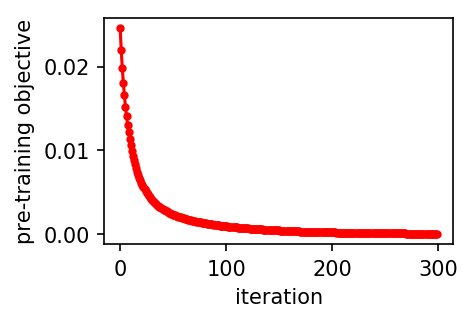

In [15]:
if OPTIONS.pre_train:
    fig, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=OPTIONS.dpi)
    ax.set_xlabel(r'iteration')
    ax.set_ylabel(r'pre-training objective')
    ax.plot(obj, '.-r')
    plt.show()


## Neural Network Training

Train the parameteric Lyapunov candidate in order to expand the verifiable safe set towards $\mathcal{S}_\pi$.

In [16]:
# Save TensorFlow checkpoint for the neural network parameters
saver = tf.train.Saver(var_list=lyapunov_nn.lyapunov_function.parameters)
ckpt_path = saver.save(session, OPTIONS.tf_checkpoint_path)


In [17]:
with tf.name_scope('roa_classification'):
    # Target the safe level set to extend out towards
    safe_level = tf.placeholder(OPTIONS.tf_dtype, shape=[], name='c_max')
    level_multiplier = tf.placeholder(OPTIONS.tf_dtype, shape=[], name='level_multiplier')
    
    # True class labels, converted from Boolean ROA labels {0, 1} to {-1, 1}
    roa_labels = tf.placeholder(OPTIONS.tf_dtype, shape=[None, 1], name='labels')
    class_labels = 2 * roa_labels - 1

    # Signed, possibly normalized distance from the decision boundary
    decision_distance = safe_level - tf_values_nn
    
    # Perceptron loss with class weights
    class_weights = tf.placeholder(OPTIONS.tf_dtype, shape=[None, 1], name='class_weights')
    classifier_loss = class_weights * tf.maximum(- class_labels * decision_distance, 0, name='classifier_loss')
    
    # Enforce decrease constraint with Lagrangian relaxation
    lagrange_multiplier = tf.placeholder(OPTIONS.tf_dtype, shape=[], name='lagrange_multiplier')
    decrease_loss = roa_labels * tf.maximum(tf_dv_nn, 0) / tf.stop_gradient(tf_values_nn + OPTIONS.eps)
        
    # Construct objective and optimizer
    objective = tf.reduce_mean(classifier_loss + lagrange_multiplier * decrease_loss, name='objective')
    learning_rate = tf.placeholder(OPTIONS.tf_dtype, shape=[], name='learning_rate')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_update = optimizer.minimize(objective, var_list=lyapunov_nn.lyapunov_function.parameters)

with tf.name_scope('sampling'):
    batch_size = tf.placeholder(tf.int32, [], 'batch_size')
    idx_range = tf.placeholder(tf.int32, shape=[], name='indices_to_sample')
    idx_batch = tf.random_uniform([batch_size, ], 0, idx_range, dtype=tf.int32, name='batch_sample')


### Initialization

Use this cell to restore parameter checkpoints and try training again.

In [18]:
saver.restore(session, ckpt_path)
lyapunov_nn.update_values()
lyapunov_nn.update_safe_set()

test_classifier_loss = []
test_decrease_loss   = []
roa_estimate         = np.copy(lyapunov_nn.safe_set)

grid              = lyapunov_nn.discretization
c_max             = [lyapunov_nn.feed_dict[lyapunov_nn.c_max], ]
safe_set_fraction = [lyapunov_nn.safe_set.sum() / grid.nindex, ]


INFO:tensorflow:Restoring parameters from ./tmp/lyapunov_function_learning.ckpt


### Training

In [19]:
# Training hyperparameters
outer_iters = 20
inner_iters = 10
horizon     = 100
test_size   = int(1e4)

feed_dict = {
    tf_states:           np.zeros((1, grid.ndim)), # placeholder
    safe_level:          1.,
    lagrange_multiplier: 1000,
    #
    level_multiplier:    1.3,
    learning_rate:       5e-3,
    batch_size:          int(1e3),
}


In [20]:
print('Current metrics ...')
c = lyapunov_nn.feed_dict[lyapunov_nn.c_max]
num_safe = lyapunov_nn.safe_set.sum()
print('Safe level (c_k): {}'.format(c))
print('Safe set size: {} ({:.2f}% of grid, {:.2f}% of ROA)\n'.format(int(num_safe), 100 * num_safe / grid.nindex, 100 * num_safe / roa.sum()))
print('')
time.sleep(0.5)

for _ in range(outer_iters):
    print('Iteration (k): {}'.format(len(c_max)))
    time.sleep(0.5)
    
    # Identify the "gap" states, i.e., those between V(c_k) and V(a * c_k) for a > 1
    c = lyapunov_nn.feed_dict[lyapunov_nn.c_max]
    idx_small = lyapunov_nn.values.ravel() <= c
    idx_big = lyapunov_nn.values.ravel() <= feed_dict[level_multiplier] * c
    idx_gap = np.logical_and(idx_big, ~idx_small)
    
    # Forward-simulate "gap" states to determine which ones we can add to our ROA estimate
    gap_states = grid.all_points[idx_gap]
    for _ in range(horizon):
        gap_states = tf_future_states.eval({tf_states: gap_states})
    gap_future_values = tf_values_nn.eval({tf_states: gap_states})    
    roa_estimate[idx_gap] |= (gap_future_values <= c).ravel()
    
    # Identify the class labels for our current ROA estimate and the expanded level set
    target_idx = np.logical_or(idx_big, roa_estimate)
    target_set = grid.all_points[target_idx]
    target_labels = roa_estimate[target_idx].astype(OPTIONS.np_dtype).reshape([-1, 1])
    feed_dict[idx_range] = target_set.shape[0]
    
    # Test set
    idx_test = idx_batch.eval({batch_size: test_size, idx_range: target_set.shape[0]})
    test_set = target_set[idx_test]
    test_labels = target_labels[idx_test]

    # SGD for classification
    for _ in tqdm(range(inner_iters)):
        # Training step
        idx_batch_eval = idx_batch.eval(feed_dict)
        feed_dict[tf_states] = target_set[idx_batch_eval]
        feed_dict[roa_labels] = target_labels[idx_batch_eval]
        feed_dict[class_weights], class_counts = balanced_class_weights(feed_dict[roa_labels].astype(bool))
        session.run(training_update, feed_dict=feed_dict)

        # Record losses on test set
        feed_dict[tf_states] = test_set
        feed_dict[roa_labels] = test_labels
        feed_dict[class_weights], class_counts = balanced_class_weights(feed_dict[roa_labels].astype(bool))
        results = session.run([classifier_loss, decrease_loss], feed_dict)
        test_classifier_loss.append(results[0].mean())
        test_decrease_loss.append(results[1].mean())

    # Update Lyapunov values and ROA estimate, based on new parameter values
    lyapunov_nn.update_values()
    lyapunov_nn.update_safe_set()
    roa_estimate |= lyapunov_nn.safe_set

    c_max.append(lyapunov_nn.feed_dict[lyapunov_nn.c_max])
    safe_set_fraction.append(lyapunov_nn.safe_set.sum() / grid.nindex)
    print('Current safe level (c_k): {}'.format(c_max[-1]))
    print('Safe set size: {} ({:.2f}% of grid, {:.2f}% of ROA)\n'.format(int(lyapunov_nn.safe_set.sum()), 
                                                                         100 * safe_set_fraction[-1], 
                                                                         100 * safe_set_fraction[-1] * roa.size / roa.sum()))


Current metrics ...
Safe level (c_k): 0.0010108091764794225
Safe set size: 495 (0.79% of grid, 2.05% of ROA)


Iteration (k): 1
Current safe level (c_k): 4.9142897699803365
Safe set size: 9617 (15.26% of grid, 39.78% of ROA)

Iteration (k): 2
Current safe level (c_k): 2.284310175890143
Safe set size: 16631 (26.40% of grid, 68.80% of ROA)

Iteration (k): 3
Current safe level (c_k): 1.477829169406441
Safe set size: 18343 (29.12% of grid, 75.88% of ROA)

Iteration (k): 4
Current safe level (c_k): 1.2043141984952492
Safe set size: 19705 (31.28% of grid, 81.52% of ROA)

Iteration (k): 5
Current safe level (c_k): 1.0523386855149028
Safe set size: 20525 (32.58% of grid, 84.91% of ROA)

Iteration (k): 6
Current safe level (c_k): 0.9823820074901526
Safe set size: 21121 (33.52% of grid, 87.37% of ROA)

Iteration (k): 7
Current safe level (c_k): 0.956406731740022
Safe set size: 21507 (34.14% of grid, 88.97% of ROA)

Iteration (k): 8
Current safe level (c_k): 0.9659126470020689
Safe set size: 2175

### Results

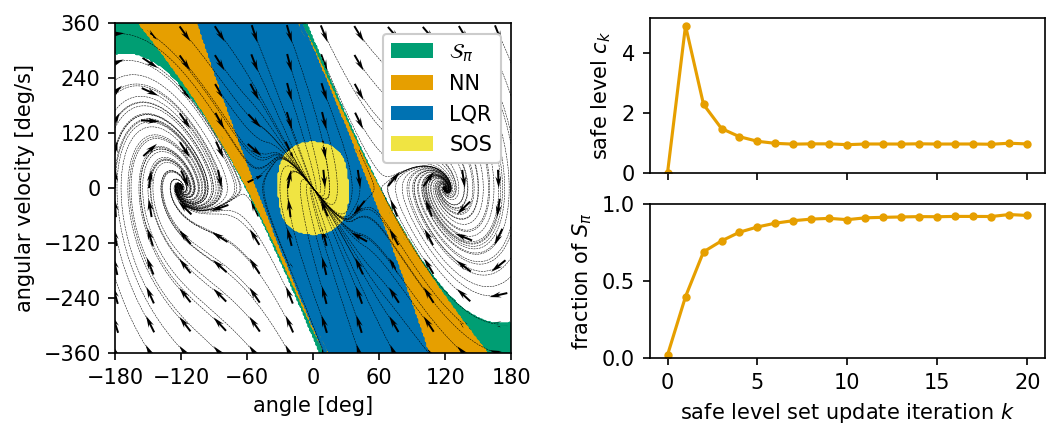

In [24]:
fig = plt.figure(figsize=(8, 3), dpi=OPTIONS.dpi, frameon=False)
fig.subplots_adjust(wspace=0.35)
plot_limits = np.column_stack((- np.rad2deg([theta_max, omega_max]), np.rad2deg([theta_max, omega_max])))

ax = plt.subplot(121)
alpha = 1
colors = [None] * 4
colors[0] = (0, 158/255, 115/255)       # ROA - bluish-green
colors[1] = (230/255, 159/255, 0)       # NN  - orange
colors[2] = (0, 114/255, 178/255)       # LQR - blue
colors[3] = (240/255, 228/255, 66/255)  # SOS - yellow

# True ROA
z = roa.reshape(grid.num_points)
ax.contour(z.T, origin='lower', extent=plot_limits.ravel(), colors=(colors[0],), linewidths=1)
ax.imshow(z.T, origin='lower', extent=plot_limits.ravel(), cmap=binary_cmap(colors[0]), alpha=alpha)

# # Neural network
z = lyapunov_nn.safe_set.reshape(grid.num_points)
ax.contour(z.T, origin='lower', extent=plot_limits.ravel(), colors=(colors[1],), linewidths=1)
ax.imshow(z.T, origin='lower', extent=plot_limits.ravel(), cmap=binary_cmap(colors[1]), alpha=alpha)

# # LQR
z = lyapunov_lqr.safe_set.reshape(grid.num_points)
ax.contour(z.T, origin='lower', extent=plot_limits.ravel(), colors=(colors[2],), linewidths=1)
ax.imshow(z.T, origin='lower', extent=plot_limits.ravel(), cmap=binary_cmap(colors[2]), alpha=alpha)

# # SOS
z = (values_sos <= cmax_sos).reshape(grid.num_points)
ax.contour(z.T, origin='lower', extent=plot_limits.ravel(), colors=(colors[3],), linewidths=1)
ax.imshow(z.T, origin='lower', extent=plot_limits.ravel(), cmap=binary_cmap(colors[3]), alpha=alpha)

# Plot some trajectories
N_traj = 11
skip = int(grid.num_points[0] / N_traj)
sub_idx = np.arange(grid.nindex).reshape(grid.num_points)
sub_idx = sub_idx[::skip, ::skip].ravel()
sub_trajectories = trajectories[sub_idx, :, :]
sub_states = grid.all_points[sub_idx]
for n in range(sub_trajectories.shape[0]):
    x = sub_trajectories[n, 0, :] * np.rad2deg(theta_max)
    y = sub_trajectories[n, 1, :] * np.rad2deg(omega_max)
    ax.plot(x, y, 'k--', linewidth=0.25)
sub_states = grid.all_points[sub_idx]
dx_dt = (tf_future_states.eval({tf_states: sub_states}) - sub_states) / dt
dx_dt = dx_dt / np.linalg.norm(dx_dt, ord=2, axis=1, keepdims=True)
ax.quiver(sub_states[:, 0] * np.rad2deg(theta_max), sub_states[:, 1] * np.rad2deg(omega_max), dx_dt[:, 0], dx_dt[:, 1], 
          scale=None, pivot='mid', headwidth=3, headlength=6, color='k')

ax.set_aspect(theta_max / omega_max / 1.2)
ax.set_xlim(plot_limits[0])
ax.set_ylim(plot_limits[1])
ax.set_xlabel(r'angle [deg]')
ax.set_ylabel(r'angular velocity [deg/s]')
ax.xaxis.set_ticks(np.arange(-180, 181, 60))
ax.yaxis.set_ticks(np.arange(-360, 361, 120))

proxy = [plt.Rectangle((0,0), 1, 1, fc=c) for c in colors]    
legend = ax.legend(proxy, [r'$\mathcal{S}_\pi$', r'NN', r'LQR', r'SOS'], loc='upper right')
legend.get_frame().set_alpha(1.)

# Plot safe growth over the iterations
ax = plt.subplot(222)
ax.plot(c_max, '.-', color=colors[1])
ax.set_ylabel(r'safe level $c_k$')
ax.set_ylim([0, None])
plt.setp(ax.get_xticklabels(), visible=False)

roa_fraction = roa.sum() / roa.size
ax = plt.subplot(224)
ax.plot(np.array(safe_set_fraction) / roa_fraction, '.-', color=colors[1])
ax.set_ylabel(r'fraction of $S_\pi$')
ax.set_ylim([0, 1])
ax.set_xlabel(r'safe level set update iteration $k$')

plt.show()
